## 1. Introduction

This dataset provides energy consumption data from various household appliances and corresponding weather information.

    Appliances connected to the smart meter include:
- Dishwasher
- Furnace
- Home office
- Fridge
- Wine cellar
- Garage door
- Kitchen
- Barn
- Well
- Microwave
- Living room
- Solar power generation

    Potential Insights:
  
By analyzing this dataset, we can explore:
- The relationship between appliance energy consumption and time periods.
- Detection of anomalous appliance usage.
- The correlation between weather data and energy generated by solar power.

    2. Goal of this Notebook

    Key Objectives:
- **Practice data pre-processing techniques.**
- **Perform Exploratory Data Analysis (EDA) for time-series data.**
- **Develop and practice data visualization techniques.**
- **Model anomaly detection using ChangeFinder.**
- **Apply time-series modeling for prediction using techniques like:**
  - Vector Autoregression (VAR)
  - Prophet
  - LightGBM Regressor
- **Enhance the interpretability of the models.**


## 2. Data load

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime, timedelta, timezone

In [4]:
dataset = pd.read_csv('./data/HomeC.csv')

C:\Users\druzh\AppData\Local\Temp\ipykernel_35068\44539944.py:1: DtypeWarning: Columns (0,27) have mixed types. Specify dtype option on import or set low_memory=False.
  dataset = pd.read_csv('./data/HomeC.csv')


In [5]:
dataset.head()

,time,use [kW],gen [kW],House overall [kW],Dishwasher [kW],Furnace 1 [kW],Furnace 2 [kW],Home office [kW],Fridge [kW],Wine cellar [kW],...,visibility,summary,apparentTemperature,pressure,windSpeed,cloudCover,windBearing,precipIntensity,dewPoint,precipProbability
0,1451624400,0.932833,0.003483,0.932833,0.000033,0.020700,0.061917,0.442633,0.124150,0.006983,...,10.0,Clear,29.26,1016.91,9.18,cloudCover,282.0,0.0,24.4,0.0
1,1451624401,0.934333,0.003467,0.934333,0.000000,0.020717,0.063817,0.444067,0.124000,0.006983,...,10.0,Clear,29.26,1016.91,9.18,cloudCover,282.0,0.0,24.4,0.0
2,1451624402,0.931817,0.003467,0.931817,0.000017,0.020700,0.062317,0.446067,0.123533,0.006983,...,10.0,Clear,29.26,1016.91,9.18,cloudCover,282.0,0.0,24.4,0.0
3,1451624403,1.022050,0.003483,1.022050,0.000017,0.106900,0.068517,0.446583,0.123133,0.006983,...,10.0,Clear,29.26,1016.91,9.18,cloudCover,282.0,0.0,24.4,0.0
4,1451624404,1.139400,0.003467,1.139400,0.000133,0.236933,0.063983,0.446533,0.122850,0.006850,...,10.0,Clear,29.26,1016.91,9.18,cloudCover,282.0,0.0,24.4,0.0


In [6]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 503911 entries, 0 to 503910
Data columns (total 32 columns):
 #   Column               Non-Null Count   Dtype  
---  ------               --------------   -----  
 0   time                 503911 non-null  object 
 1   use [kW]             503910 non-null  float64
 2   gen [kW]             503910 non-null  float64
 3   House overall [kW]   503910 non-null  float64
 4   Dishwasher [kW]      503910 non-null  float64
 5   Furnace 1 [kW]       503910 non-null  float64
 6   Furnace 2 [kW]       503910 non-null  float64
 7   Home office [kW]     503910 non-null  float64
 8   Fridge [kW]          503910 non-null  float64
 9   Wine cellar [kW]     503910 non-null  float64
 10  Garage door [kW]     503910 non-null  float64
 11  Kitchen 12 [kW]      503910 non-null  float64
 12  Kitchen 14 [kW]      503910 non-null  float64
 13  Kitchen 38 [kW]      503910 non-null  float64
 14  Barn [kW]            503910 non-null  float64
 15  Well [kW]        

In [7]:
def convert_series_to_float(series: pd.Series) -> pd.Series:
    return pd.to_numeric(series, errors='coerce')

In [8]:
dataset['time'] = convert_series_to_float(dataset['time'])

In [9]:
dataset['cloudCover'].replace(['cloudCover'], method='bfill', inplace=True)
dataset['cloudCover'] = pd.to_numeric(dataset['cloudCover'], errors='coerce')

In [10]:
dataset.isna().sum()

time                   1
use [kW]               1
gen [kW]               1
House overall [kW]     1
Dishwasher [kW]        1
Furnace 1 [kW]         1
Furnace 2 [kW]         1
Home office [kW]       1
Fridge [kW]            1
Wine cellar [kW]       1
Garage door [kW]       1
Kitchen 12 [kW]        1
Kitchen 14 [kW]        1
Kitchen 38 [kW]        1
Barn [kW]              1
Well [kW]              1
Microwave [kW]         1
Living room [kW]       1
Solar [kW]             1
temperature            1
icon                   1
humidity               1
visibility             1
summary                1
apparentTemperature    1
pressure               1
windSpeed              1
cloudCover             1
windBearing            1
precipIntensity        1
dewPoint               1
precipProbability      1
dtype: int64

In [11]:
dataset.dropna(inplace=True)

In [12]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 503910 entries, 0 to 503909
Data columns (total 32 columns):
 #   Column               Non-Null Count   Dtype  
---  ------               --------------   -----  
 0   time                 503910 non-null  float64
 1   use [kW]             503910 non-null  float64
 2   gen [kW]             503910 non-null  float64
 3   House overall [kW]   503910 non-null  float64
 4   Dishwasher [kW]      503910 non-null  float64
 5   Furnace 1 [kW]       503910 non-null  float64
 6   Furnace 2 [kW]       503910 non-null  float64
 7   Home office [kW]     503910 non-null  float64
 8   Fridge [kW]          503910 non-null  float64
 9   Wine cellar [kW]     503910 non-null  float64
 10  Garage door [kW]     503910 non-null  float64
 11  Kitchen 12 [kW]      503910 non-null  float64
 12  Kitchen 14 [kW]      503910 non-null  float64
 13  Kitchen 38 [kW]      503910 non-null  float64
 14  Barn [kW]            503910 non-null  float64
 15  Well [kW]        

In [13]:
dataset['time'][0]

1451624400.0

In [14]:
dataset['time'][1]

1451624401.0

### Time column
The time column seems to be in UNIX format (seconds passed since January 1st, 1970).

The timezone is not specified. Let's first transform the data into human readable form, assuming that the timezone is UTC.

In [16]:
pd.to_datetime(dataset['time'], unit='s').head(3) # problem is that in data describtion it states to be an every minute record

0   2016-01-01 05:00:00
1   2016-01-01 05:00:01
2   2016-01-01 05:00:02
Name: time, dtype: datetime64[ns]

In [17]:
def get_df_index(df, h=0, freq='1T'):
    start_time = datetime.fromtimestamp(int(df['time'].iloc[0]), timezone(timedelta(hours=h))).strftime('%Y-%m-%d %H:%M')
    end_time = datetime.fromtimestamp(int(df['time'].iloc[-1]), timezone(timedelta(hours=h))).strftime('%Y-%m-%d %H:%M')
    minute_index = pd.date_range(start_time, periods=len(df), freq=freq) # instruction say frequency is 1 minute
    return minute_index

In [18]:
minute_index = get_df_index(dataset, h=-5, freq='1T')

In [19]:
dataset.set_index(minute_index,inplace=True)

In [20]:
# dataset['time'] = pd.to_datetime(dataset['time'], unit='s')

In [21]:
def extract_time_features(df):
    df['hour'] = df.index.hour
    df['day'] = df.index.day
    df['weekday'] = df.index.weekday
    df['month'] = df.index.month
    df['year'] = df.index.year
    df['minute'] = df.index.minute
    return df

In [22]:
dataset = extract_time_features(dataset)

In [23]:
dataset.drop(['icon','summary'],axis=1,inplace=True) # removed categorical values

In [24]:
#  We don't need to be that specific about number of furnaces or kitchen so lets unite them
dataset['Furnace'] = dataset['Furnace 1 [kW]'] + dataset['Furnace 2 [kW]']
dataset['Kitchen'] = dataset['Kitchen 12 [kW]'] + dataset['Kitchen 14 [kW]'] + dataset['Kitchen 38 [kW]']
dataset.drop(['Furnace 1 [kW]','Furnace 2 [kW]','Kitchen 12 [kW]','Kitchen 14 [kW]','Kitchen 38 [kW]'],axis=1,inplace=True)

<Axes: >

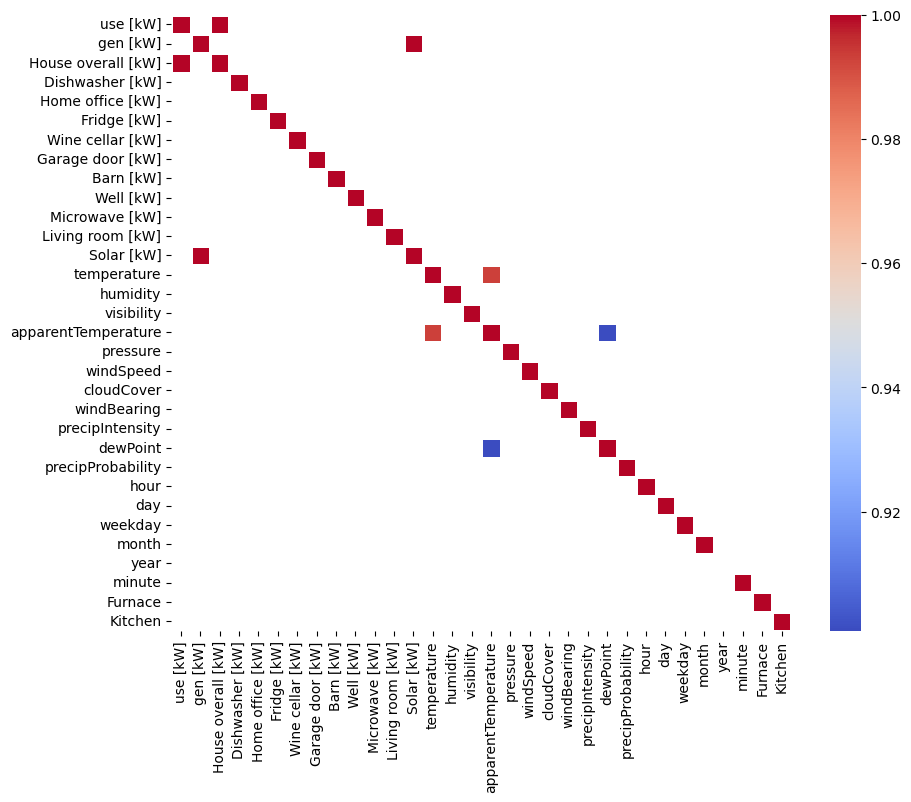

In [25]:
fig = plt.subplots(figsize=(10, 8))
sns.heatmap(dataset.drop('time',axis=1).corr()[dataset.corr() >= 0.9],cmap='coolwarm',linewidth=1)
# highly correlated 'use' ,'House overall' and 'gen','Solar' and 'temp' and 'apparentTemp'

In [26]:
dataset['use_house'] = dataset['use [kW]']
dataset['gen_sol'] = dataset['gen [kW]']
dataset.drop(['use [kW]','House overall [kW]','gen [kW]','Solar [kW]','apparentTemperature'], axis=1, inplace=True)

In [27]:
dataset.drop('time',axis=1,inplace=True)

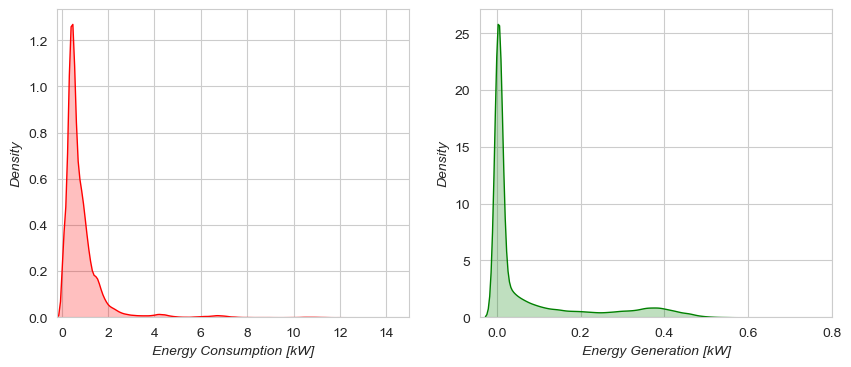

In [28]:
sns.set_style('whitegrid')
fig, ax = plt.subplots(1,2,figsize=(10,4))
ax = ax.flatten()
sns.kdeplot(dataset,x='use_house',ax=ax[0],fill=True,color='r')
ax[0].set_xlim(-0.2,15)
ax[0].set_xlabel('Energy Consumption [kW]',fontstyle='italic')
ax[0].set_ylabel('Density',fontstyle='italic')

sns.kdeplot(dataset,x='gen_sol',ax=ax[1],fill=True,color='g')
ax[1].set_xlim(-0.04,0.8)
ax[1].set_xlabel('Energy Generation [kW]',fontstyle='italic')
ax[1].set_ylabel('Density',fontstyle='italic')
plt.show()

In [29]:
daily = dataset.resample('D').mean()
hourly = dataset.resample('H').mean()
# minutely = dataset.resample('10min').mean()

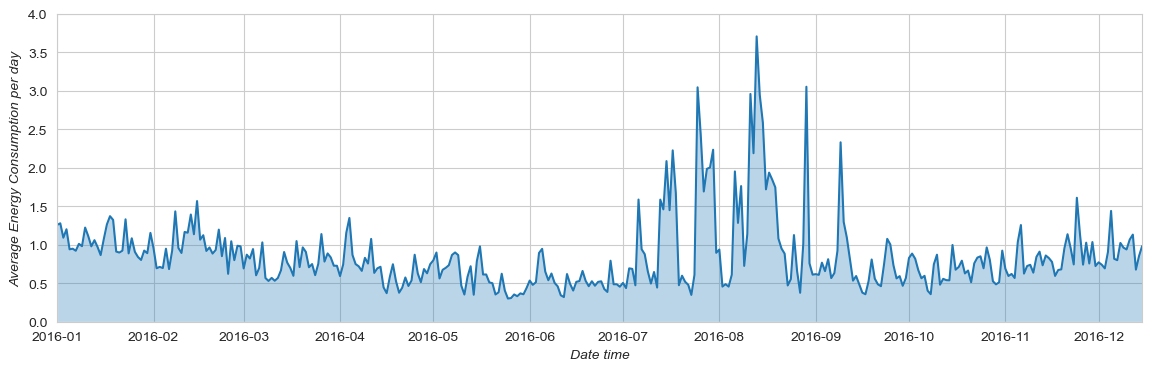

In [30]:
plt.figure(figsize=(14,4))
sns.lineplot(daily, x=daily.index, y='use_house')
plt.fill_between(daily.index, daily['use_house'], alpha=0.3)
plt.xlabel('Date time',fontstyle='italic')
plt.ylabel('Average Energy Consumption per day', fontstyle='italic')
plt.xlim(daily.index[0],daily.index[-1])
plt.ylim(0,4)
plt.show()

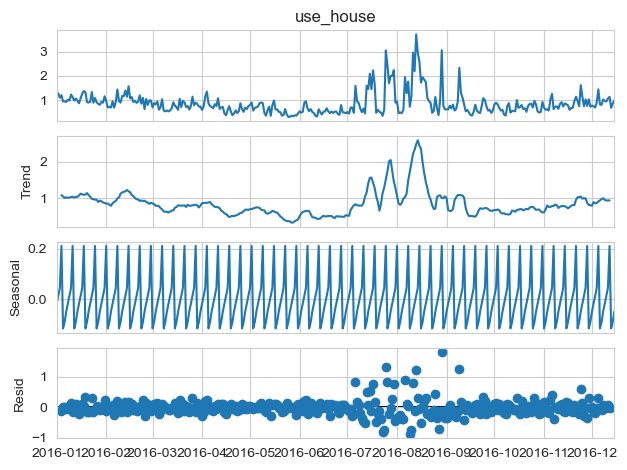

In [103]:
from statsmodels.tsa.seasonal import seasonal_decompose

#  strong weekly seasonality
result = seasonal_decompose(daily['use_house'], model='additive')
result.plot()
plt.show()

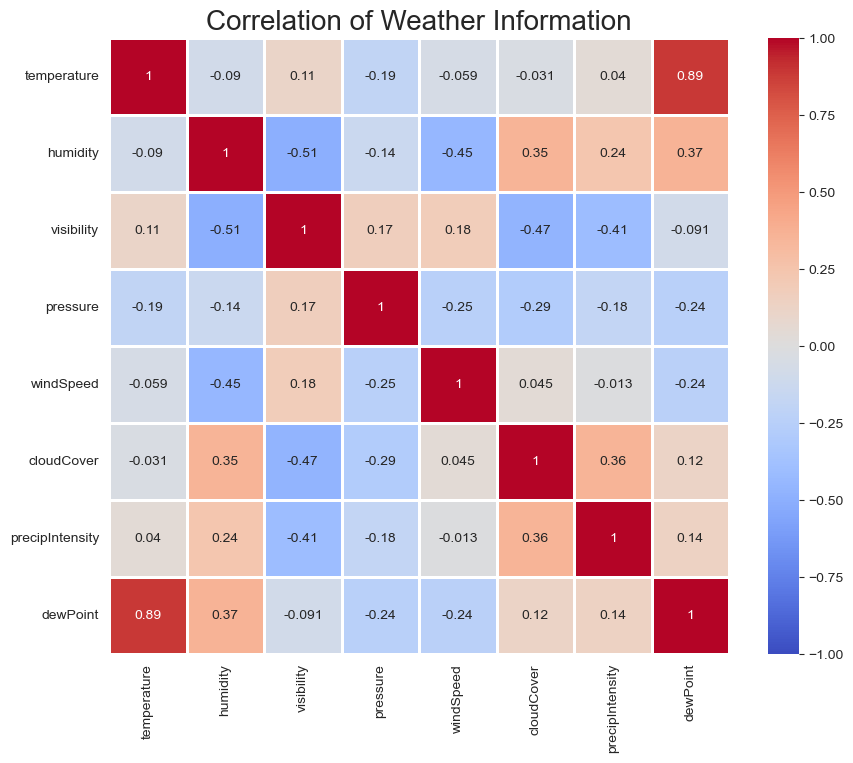

In [117]:
weather = ['temperature',
           'humidity',
           'visibility',
           'pressure',
           'windSpeed',
           'cloudCover',
           'precipIntensity',
           'dewPoint']

fig,ax = plt.subplots(figsize=(10, 8))
sns.heatmap(dataset[weather].corr(), annot=True, vmin=-1.0, vmax=1.0, center=0,cmap='coolwarm',linewidth=1)
ax.set_title('Correlation of Weather Information',size=20)
plt.show()

### Some weather information is correlated each other.
Temperature is related dewPoint.

Humidity is related to visibility, windSpeed, cloudCover and dewPoint.

Visibility is related to humidity, windSpeed, cloudCover and precipIntensity.

CloudCover is related to humidity, visibility and precipIntensity.

PrecipIntensity is related to visibility and cloudCover.

DewPoint is related to temperature.

In [172]:
from scipy import stats
daily['z_score'] = stats.zscore(daily['use_house'])
anomalies_z = daily[daily['z_score'].abs() > 1.5]

(0.0, 4.0)

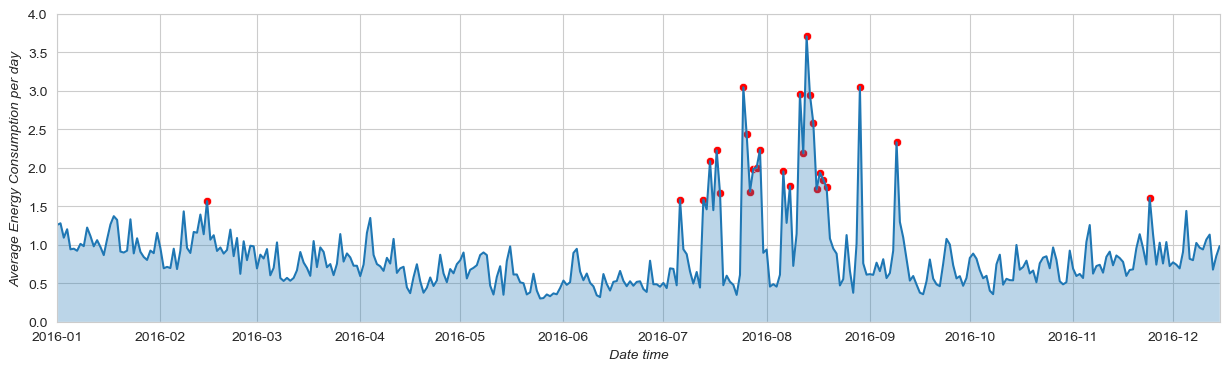

In [176]:
plt.figure(figsize=(15,4))
sns.scatterplot(anomalies_z,x=anomalies_z.index,y='use_house',color='r')
sns.lineplot(daily, x=daily.index, y='use_house')
plt.fill_between(daily.index, daily['use_house'], alpha=0.3)
plt.xlabel('Date time',fontstyle='italic')
plt.ylabel('Average Energy Consumption per day', fontstyle='italic')
plt.xlim(daily.index[0],daily.index[-1])
plt.ylim(0,4)

In [178]:
Q1 = daily['use_house'].quantile(0.25)
Q3 = daily['use_house'].quantile(0.75)
IQR = Q3 - Q1

lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

anomalies_iqr = daily[(daily['use_house'] < lower_bound) | (daily['use_house'] > upper_bound)]

(0.0, 4.0)

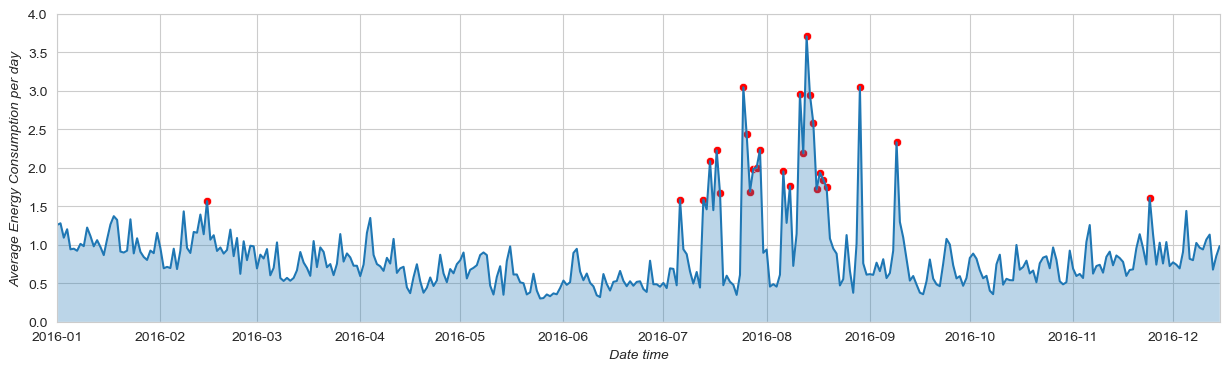

In [183]:
plt.figure(figsize=(15,4))
sns.scatterplot(anomalies_iqr,x=anomalies_iqr.index,y='use_house',color='r')
sns.lineplot(daily, x=daily.index, y='use_house')
plt.fill_between(daily.index, daily['use_house'], alpha=0.3)
plt.xlabel('Date time',fontstyle='italic')
plt.ylabel('Average Energy Consumption per day', fontstyle='italic')
plt.xlim(daily.index[0],daily.index[-1])
plt.ylim(0,4)

In [197]:
from sklearn.ensemble import IsolationForest

iso_forest = IsolationForest(contamination=0.1)
daily['anomaly_iforest'] = iso_forest.fit_predict(daily[['use_house']])

anomalies_iforest = daily[daily['anomaly_iforest'] == -1]

(0.0, 4.0)

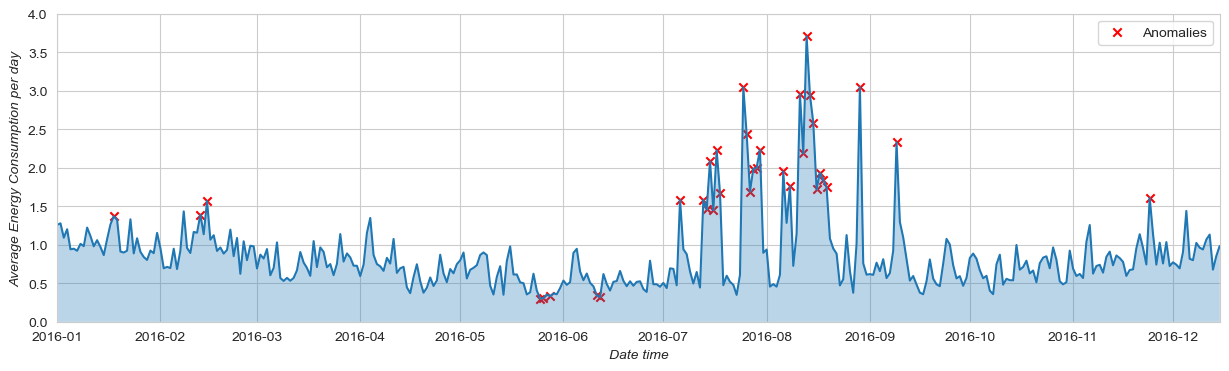

In [199]:
plt.figure(figsize=(15,4))
plt.scatter(anomalies_iforest.index, anomalies_iforest['use_house'], color='red', label='Anomalies', marker='x')
sns.lineplot(daily, x=daily.index, y='use_house')
plt.fill_between(daily.index, daily['use_house'], alpha=0.3)
plt.xlabel('Date time',fontstyle='italic')
plt.ylabel('Average Energy Consumption per day', fontstyle='italic')
plt.xlim(daily.index[0],daily.index[-1])
plt.ylim(0,4)

In [295]:
from sklearn.model_selection import train_test_split

steps = 30 # 30 days prediction

train_set, test_set = train_test_split(daily,train_size=daily.shape[0]-steps)

In [297]:
import pmdarima as pm

sarima_model = pm.auto_arima(daily['use_house'], start_p=1, start_q=1,
                         test='adf',
                         max_p=3, max_q=3, m=12,
                         start_P=0, seasonal=True,
                         d=None, D=1, trace=True,
                         error_action='ignore',  
                         suppress_warnings=True, 
                         stepwise=True)

sarima_model.summary()

Performing stepwise search to minimize aic
 ARIMA(1,0,1)(0,1,1)[12] intercept   : AIC=inf, Time=3.56 sec
 ARIMA(0,0,0)(0,1,0)[12] intercept   : AIC=573.676, Time=0.24 sec
 ARIMA(1,0,0)(1,1,0)[12] intercept   : AIC=397.857, Time=0.85 sec
 ARIMA(0,0,1)(0,1,1)[12] intercept   : AIC=inf, Time=2.60 sec
 ARIMA(0,0,0)(0,1,0)[12]             : AIC=571.693, Time=0.10 sec
 ARIMA(1,0,0)(0,1,0)[12] intercept   : AIC=454.685, Time=0.30 sec
 ARIMA(1,0,0)(2,1,0)[12] intercept   : AIC=377.860, Time=2.00 sec
 ARIMA(1,0,0)(2,1,1)[12] intercept   : AIC=inf, Time=8.45 sec
 ARIMA(1,0,0)(1,1,1)[12] intercept   : AIC=inf, Time=3.40 sec
 ARIMA(0,0,0)(2,1,0)[12] intercept   : AIC=520.807, Time=1.49 sec
 ARIMA(2,0,0)(2,1,0)[12] intercept   : AIC=375.506, Time=2.52 sec
 ARIMA(2,0,0)(1,1,0)[12] intercept   : AIC=397.451, Time=0.99 sec
 ARIMA(2,0,0)(2,1,1)[12] intercept   : AIC=inf, Time=8.36 sec
 ARIMA(2,0,0)(1,1,1)[12] intercept   : AIC=inf, Time=3.95 sec
 ARIMA(3,0,0)(2,1,0)[12] intercept   : AIC=377.175, Time=

<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                      
===========================================================================================
Dep. Variable:                                   y   No. Observations:                  350
Model:             SARIMAX(1, 0, 1)x(2, 1, [], 12)   Log Likelihood                -181.654
Date:                             Fri, 20 Sep 2024   AIC                            373.308
Time:                                     19:31:27   BIC                            392.423
Sample:                                 01-01-2016   HQIC                           380.926
                                      - 12-15-2016                                         
Covariance Type:                               opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.7191      0.042     16.930      0.000       0.636       0.802
ma.L1         -0.1937      0.050     -3.909      0.000      -0.291      -0.097
ar.S.L12      -0.5055      0.030    -16.995      0.000      -0.564      -0.447
ar.S.L24      -0.2662      0.035     -7.598      0.000      -0.335      -0.198
sigma2         0.1694      0.006     27.967      0.000       0.157       0.181
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):               997.97
Prob(Q):                              0.99   Prob(JB):                         0.00
Heteroskedasticity (H):               4.00   Skew:                             0.42
Prob(H) (two-sided):                  0.00   Kurtosis:                        11.38
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

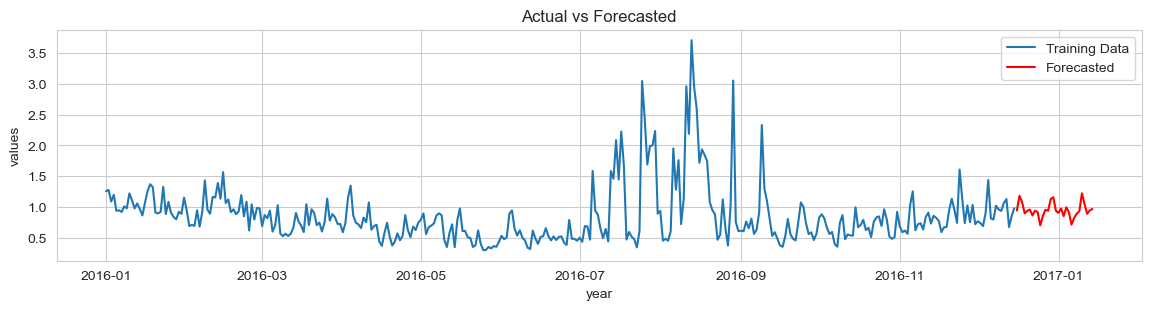

In [301]:
plt.figure(figsize=(14,3))
plt.plot(daily.index, daily['use_house'], label='Training Data')
plt.plot(sarima_model.predict(n_periods=30).index, sarima_model.predict(n_periods=30), label='Forecasted', color='red')
plt.legend()
plt.title('Actual vs Forecasted')
plt.xlabel('year')
plt.ylabel('values')
plt.show()

In [293]:
sarima_model.predict().shape

(10,)

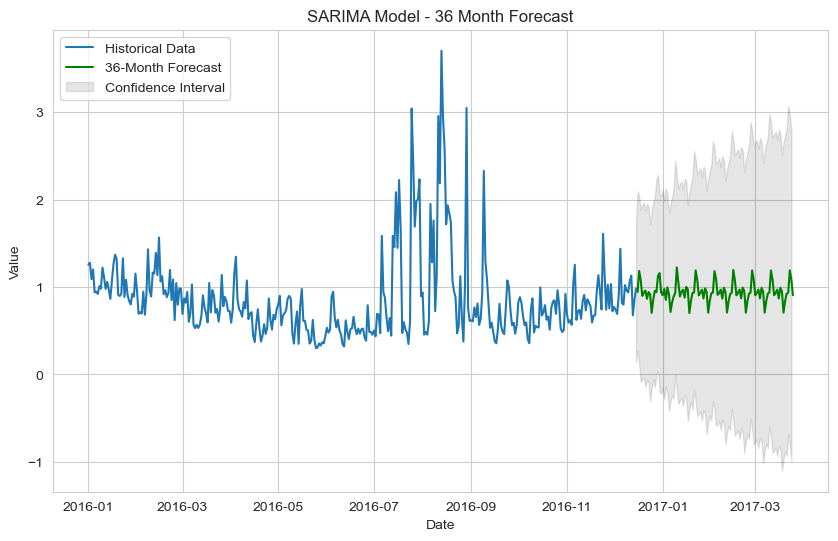

In [284]:
n_periods = 100
forecast, conf_int = sarima_model.predict(n_periods=n_periods, return_conf_int=True)

index_of_fc = pd.date_range(daily.index[-1], periods=n_periods, freq='D')

forecast_df = pd.DataFrame(forecast)
conf_df = pd.DataFrame(conf_int, index=index_of_fc, columns=['Lower Bound', 'Upper Bound'])

plt.figure(figsize=(10, 6))

plt.plot(daily['use_house'], label='Historical Data')

# Plot the forecasted values
plt.plot(forecast_df, label='36-Month Forecast', color='green')

# Plot the confidence intervals
plt.fill_between(index_of_fc, conf_df['Lower Bound'], conf_df['Upper Bound'], 
                 color='k', alpha=0.1, label='Confidence Interval')

plt.title('SARIMA Model - 36 Month Forecast')
plt.xlabel('Date')
plt.ylabel('Value')
plt.legend(loc='upper left', fontsize=10)
plt.grid(True)
plt.show()

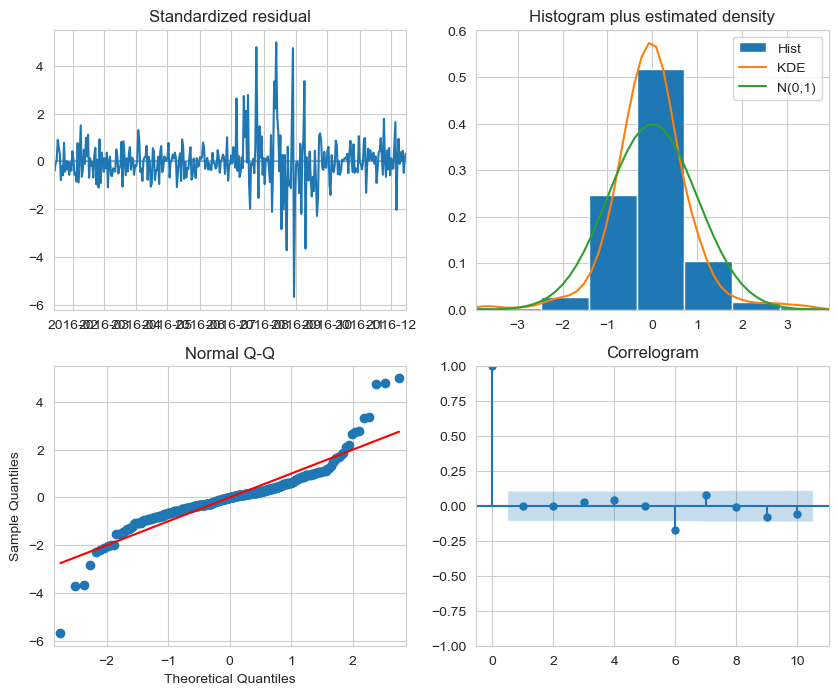

In [304]:
sarima_model.plot_diagnostics(figsize=(10,8))
plt.show()

2016-01-01    1
2016-01-02    1
2016-01-03    1
2016-01-04    1
2016-01-05    1
             ..
2016-12-11    1
2016-12-12    1
2016-12-13    1
2016-12-14    1
2016-12-15    1
Freq: D, Name: anomaly_iforest, Length: 350, dtype: int32

In [318]:
from scipy import stats

# Copy the original column
daily['use_house_transformed'] = daily['use_house']

# Select the rows where anomalies are present and positive values exist
anomalies_positive = daily[(daily['anomaly_iforest'] == 1) & (daily['use_house'] > 0)]

# Apply Box-Cox transformation only to the selected rows
transformed_values, lambda_bc = stats.boxcox(anomalies_positive['use_house'])

# Update the transformed values in the 'use_house_transformed' column
daily.loc[anomalies_positive.index, 'use_house_transformed'] = transformed_values

In [320]:
sarima_model_transformed = pm.auto_arima(daily['use_house_transformed'], start_p=1, start_q=1,
                                         test='adf',
                                         max_p=3, max_q=3, m=12,
                                         start_P=0, seasonal=True,
                                         d=None, D=1, trace=True,
                                         error_action='ignore',  
                                         suppress_warnings=True, 
                                         stepwise=True)

sarima_model_transformed.summary()

Performing stepwise search to minimize aic
 ARIMA(1,0,1)(0,1,1)[12] intercept   : AIC=inf, Time=3.54 sec
 ARIMA(0,0,0)(0,1,0)[12] intercept   : AIC=885.796, Time=0.37 sec
 ARIMA(1,0,0)(1,1,0)[12] intercept   : AIC=710.904, Time=0.68 sec
 ARIMA(0,0,1)(0,1,1)[12] intercept   : AIC=inf, Time=2.57 sec
 ARIMA(0,0,0)(0,1,0)[12]             : AIC=883.804, Time=0.10 sec
 ARIMA(1,0,0)(0,1,0)[12] intercept   : AIC=779.455, Time=0.26 sec
 ARIMA(1,0,0)(2,1,0)[12] intercept   : AIC=691.410, Time=1.58 sec
 ARIMA(1,0,0)(2,1,1)[12] intercept   : AIC=inf, Time=6.38 sec
 ARIMA(1,0,0)(1,1,1)[12] intercept   : AIC=inf, Time=3.54 sec
 ARIMA(0,0,0)(2,1,0)[12] intercept   : AIC=830.327, Time=1.40 sec
 ARIMA(2,0,0)(2,1,0)[12] intercept   : AIC=684.651, Time=1.46 sec
 ARIMA(2,0,0)(1,1,0)[12] intercept   : AIC=706.040, Time=0.89 sec
 ARIMA(2,0,0)(2,1,1)[12] intercept   : AIC=inf, Time=8.21 sec
 ARIMA(2,0,0)(1,1,1)[12] intercept   : AIC=inf, Time=5.10 sec
 ARIMA(3,0,0)(2,1,0)[12] intercept   : AIC=686.650, Time=

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:                                  y   No. Observations:                  350
Model:             SARIMAX(2, 0, 0)x(2, 1, 0, 12)   Log Likelihood                -336.330
Date:                            Fri, 20 Sep 2024   AIC                            682.659
Time:                                    19:58:46   BIC                            701.774
Sample:                                01-01-2016   HQIC                           690.277
                                     - 12-15-2016                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.4966      0.029     17.185      0.000       0.440       0.553
ar.L2          0.1605      0.036      4.443      0.000       0.090       0.231
ar.S.L12      -0.5428      0.029    -18.549      0.000      -0.600      -0.485
ar.S.L24      -0.2590      0.040     -6.396      0.000      -0.338      -0.180
sigma2         0.4226      0.016     25.910      0.000       0.391       0.455
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):               650.35
Prob(Q):                              0.98   Prob(JB):                         0.00
Heteroskedasticity (H):               3.60   Skew:                             0.17
Prob(H) (two-sided):                  0.00   Kurtosis:                         9.79
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

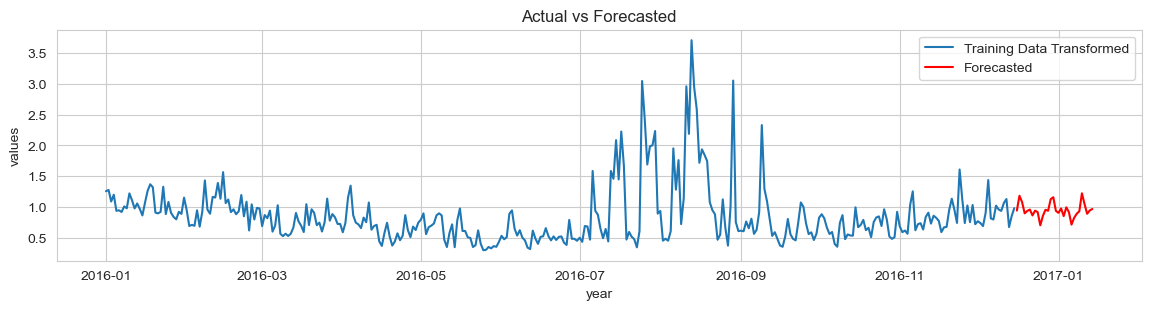

In [324]:
plt.figure(figsize=(14,3))
plt.plot(daily.index, daily['use_house'], label='Training Data Transformed')
plt.plot(sarima_model_transformed.predict(n_periods=30).index, sarima_model.predict(n_periods=30), label='Forecasted', color='red')
plt.legend()
plt.title('Actual vs Forecasted')
plt.xlabel('year')
plt.ylabel('values')
plt.show()